In [1]:
# to show pictures direcly in the code  
%matplotlib inline 

# required packages
import numpy as np
import pandas as pd
import os

In [246]:
store.close()

In [2]:
# Packages for plotting, not sure if all is really necessary
import matplotlib.pyplot as plt

from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, NumeralTickFormatter
from bokeh.charts.attributes import color

output_notebook() # another one for plotting graphs are directly plotted in this notebook

Loading BokehJS ...

# Read DanskGasDistribution Data
- Usage of gas (m3) per
    - month
    - company (possible to refer back to industry sector)
    - process

In [3]:
dgd = pd.read_excel('input/Kørsel 13 januar 2017 med branchekoder.xlsx', 
                     sheetname='_Ark1',
                     encoding='UTF8',
                     thousands=',',
                     decimals='.',
                     header = 0)

In [4]:
dgd.head()

PARTNER               MC_NAME1 MC_NAME2 area forbrugssted  \
0  300156.0  CARLSBERG DANMARK A/S      NaN  DK1     1/300156   
1  300156.0  CARLSBERG DANMARK A/S      NaN  DK1     1/300156   
2  300156.0  CARLSBERG DANMARK A/S      NaN  DK1     1/300156   
3  300156.0  CARLSBERG DANMARK A/S      NaN  DK1     1/300156   
4  300156.0  CARLSBERG DANMARK A/S      NaN  DK1     1/300156   

  anvendelsesformaal  haeldning  haeldning_pris  MAANED  normal_aar_grad_dage  \
0                K/V        NaN             NaN       1                   NaN   
1                K/V        NaN             NaN       2                   NaN   
2                K/V        NaN             NaN       3                   NaN   
3                K/V        NaN             NaN       4                   NaN   
4                K/V        NaN             NaN       5                   NaN   

      ...      prognose_for_normal_dsm_kr budget_dsm_kr             koersel  \
0     ...                             0.0           0.0 2017-01-13 09:49:53   
1     ...                             0.0           0.0 2017-01-13 09:49:53   
2     ...                             0.0           0.0 2017-01-13 09:49:53   
3     ...                             0.0           0.0 2017-01-13 09:49:53   
4     ...                             0.0           0.0 2017-01-13 09:49:53   

   klassifikation  share  klassifikation_budget  share_budget  abonnement  \
0             DMS    0.5                  nDMSm           0.5         0.0   
1             DMS    0.5                  nDMSm           0.5         0.0   
2             DMS    0.5                  nDMSm           0.5         0.0   
3             DMS    0.5                  nDMSm           0.5         0.0   
4             DMS    0.5                  nDMSm           0.5         0.0   

   abonnement_budget  IND_SECTOR  
0                0.0    11.05.00  
1                0.0    11.05.00  
2                0.0    11.05.00  
3                0.0    11.05.00  
4                0.0    11.05.00  

[5 rows x 37 columns]

In [5]:
# reduce to the columns we use
dgd = dgd.loc[:,['MC_NAME1','anvendelsesformaal','MAANED','realiseret_forbrug','IND_SECTOR']]
# translate column names to English
dgd.columns = ['company','use','month','consumption','industry_db07']
dgd.head(3)

company  use  month  consumption industry_db07
0  CARLSBERG DANMARK A/S  K/V      1     956299.0      11.05.00
1  CARLSBERG DANMARK A/S  K/V      2    1478655.0      11.05.00
2  CARLSBERG DANMARK A/S  K/V      3     579219.0      11.05.00

In [6]:
# At the end of the list there is blank lines for company, probably these are residential customers, summed.
# these blank lines (nan) are replaced by 'no_company' and 'no_industry', for including in grouping
dgd.company.replace(np.nan, 'no_company', inplace = True)
dgd.industry_db07.replace(np.nan, 'no_industry', inplace = True)

In [49]:
# grouping by company, use, month, industry, summing up consumption
# dividing by 3 because it seems like all lines are there three times
dgd_by_company = pd.DataFrame(dgd.groupby(['company','use','month','industry_db07'])['consumption'].
                              sum()/3).reset_index(drop = False)

In [50]:
# check for sum, yearly sum from the original data is: 0.701916509 km3 =  701,916,509 m3
dgd_by_company.consumption.sum()

701916508.7153083

In [51]:
# translate the uses
dgd_expla = pd.read_excel('input/Kørsel 13 januar 2017 med branchekoder.xlsx', 
                          sheetname='explanation',
                          encoding='UTF8',
                          header = 0)

# Set up dictionary for the uses
use_dict = dgd_expla[['anvendelsesformaal','use']].set_index('anvendelsesformaal')['use'].to_dict()

# replace Danish expressions
dgd_by_company.use.replace(use_dict, inplace=True)

In [52]:
# Prepare for plotting the summed values of each use over the year
# values tranformed to million m3, so that it easier to read on the graphs
dgd_sum_by_use = pd.DataFrame(dgd_by_company.groupby(['use','month'])['consumption'].
                              sum()/1000000).reset_index(drop=False)

# show
dgd_sum_by_use.head()

use  month  consumption
0  below_75000      1     7.247741
1  below_75000      2     5.498100
2  below_75000      3     4.921379
3  below_75000      4     3.495683
4  below_75000      5     1.883665

In [53]:
pd.Series(dgd_sum_by_use.use.unique())

0                     below_75000
1    cheap_tariff_filling_station
2           cheap_tariff_industry
3                             chp
4                    dh_gasboiler
5                 filling_station
6                      over_75000
7                 small_customers
dtype: object

In [54]:
color = ['Blue','Green','Orange','Red','Lightblue','Darkgreen','Grey','Brown']
'blue','green','orange','red','lightblue','darkgreen','grey','brown'

('blue', 'green', 'orange', 'red', 'lightblue', 'darkgreen', 'grey', 'brown')

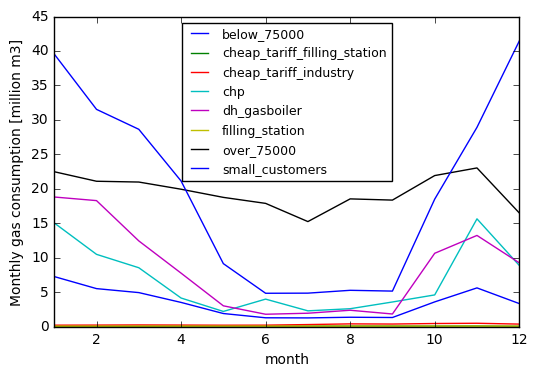

In [55]:
fig, ax = plt.subplots(1,1)
dgd_sum_by_use.groupby("use").plot(x="month", y="consumption", ax=ax)

plt.legend([v[0] for v in dgd_sum_by_use.groupby('use')['use']],prop={'size':9},loc='best')
plt.ylabel('Monthly gas consumption [million m3]', fontsize=10)
plt.savefig('YearlyProfilesGas.png', bbox_inches='tight')

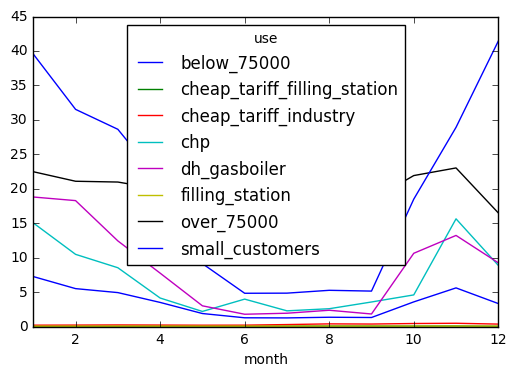

In [56]:
pivoted = pd.pivot_table(dgd_sum_by_use, values='consumption', columns='use', index='month')
# Now there will be an index column for date and value columns for 0,1,2,3,4
pivoted.plot()

use
below_75000                     Axes(0.125,0.125;0.775x0.775)
cheap_tariff_filling_station    Axes(0.125,0.125;0.775x0.775)
cheap_tariff_industry           Axes(0.125,0.125;0.775x0.775)
chp                             Axes(0.125,0.125;0.775x0.775)
dh_gasboiler                    Axes(0.125,0.125;0.775x0.775)
filling_station                 Axes(0.125,0.125;0.775x0.775)
over_75000                      Axes(0.125,0.125;0.775x0.775)
small_customers                 Axes(0.125,0.125;0.775x0.775)
dtype: object

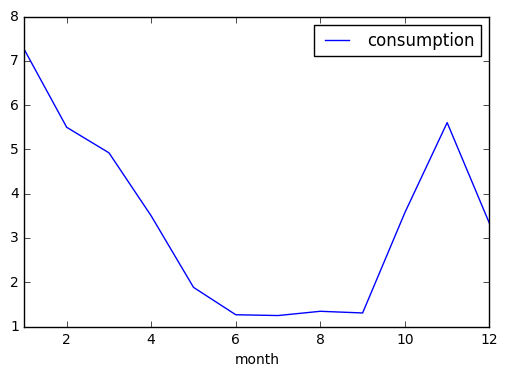

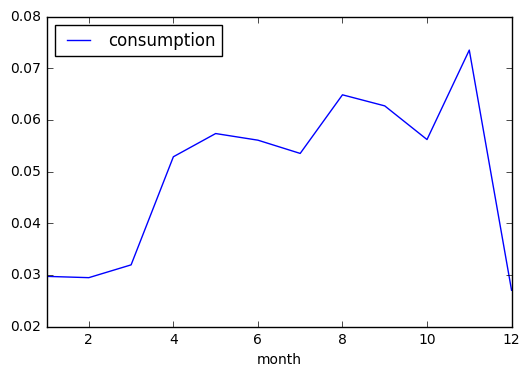

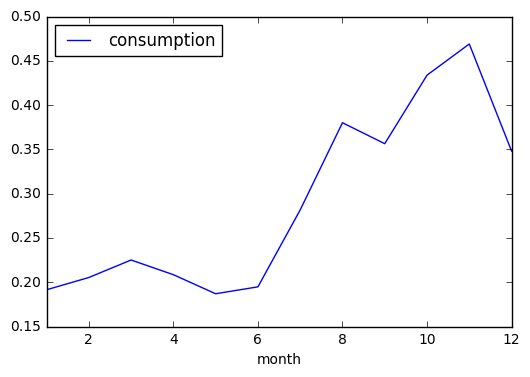

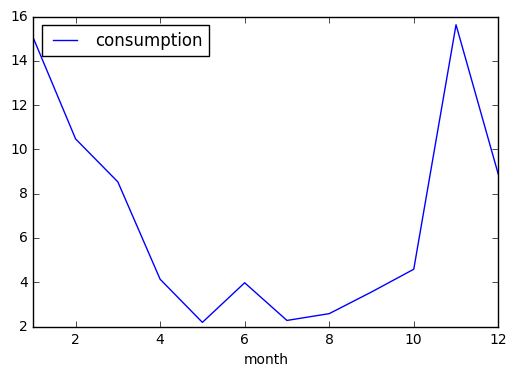

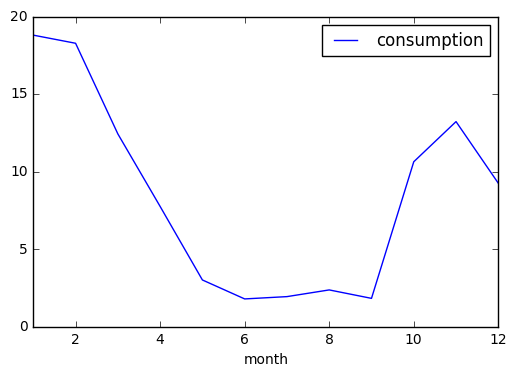

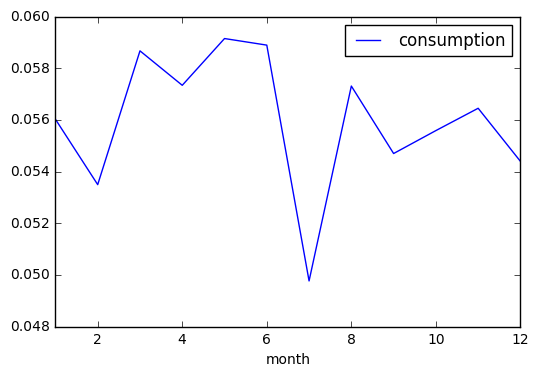

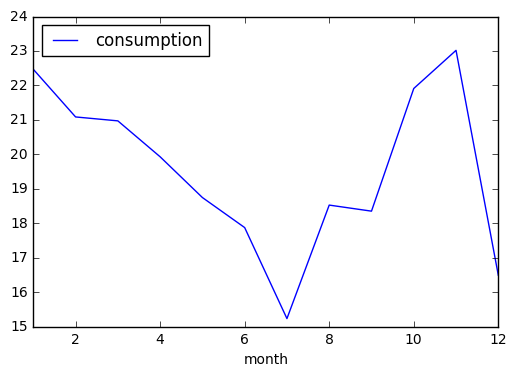

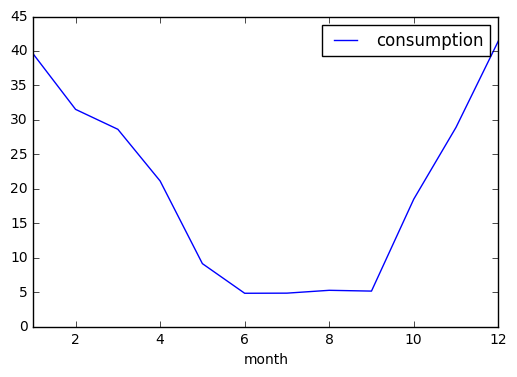

In [57]:
dgd_sum_by_use.groupby('use').plot(x='month', y="consumption")

## Matching industry sectors DGD - VMAS
- DGD: 6-digit DB07
- VMAS: summarized 57 sectors based on DB07

In [58]:
# Read the matching file for getting the relation between DB07 Codes (which DGD uses) and the slightly different
# VMAS 57 sectors categorization, which I took originally from the report Erverherhvskortlagning
matchDB07 = pd.read_excel('input/MatchingDB07_VMAS.xlsx', 
                     sheetname='Sheet1',
                     encoding='UTF8',
                     thousands=',',
                     decimals='.',
                     header = 0)

# This one is required for getting the English VMAS names
MatchingIndustry = pd.read_excel('input/MatchingIndustry.xlsx', 
                            sheetname='Sheet1',
                            encoding='UTF8',
                            thousands=',',
                            decimals='.',
                            header = 0)

### Prepare for matching Danish and English industry names and DB07 codes for VMAS data + aggregation

In [59]:
# adapt column names
matchDB07.columns = ['DB07_text_agg','DB07','DB07_text','std127','std127_text','Industry_VM_dk']

# get rid of the f**king whitespace at the end of the DB-code
matchDB07['DB07'] = matchDB07['DB07'].str.strip()

In [60]:
# Add the single, double, triple information to the production
idx_prod = MatchingIndustry[MatchingIndustry['Industry_VM_en_agg'] == 'Production'].index

MatchingIndustry.loc[idx_prod,'Industry_VM_en_agg'] = (MatchingIndustry.loc[idx_prod,'Industry_VM_en_agg'] + 
                                                       '_' + MatchingIndustry.loc[idx_prod,'Shift'])

In [61]:
idx_prod

Int64Index([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
            22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
            39, 40, 41, 42, 43],
           dtype='int64')

In [62]:
# add the English VMAS-Codes to the preprocessed dgd dataframe in three steps
# Step1: Match DB07 to Industry_VM_dk
dict_DB07 = matchDB07[['DB07','Industry_VM_dk']].set_index('DB07')['Industry_VM_dk'].to_dict()

# Step2: Replace Industry_VM_dk by the English one
dict_VM_dk_en = MatchingIndustry[['Industry_VM_dk_no_number','Industry_VM_en'
                                 ]].set_index('Industry_VM_dk_no_number')['Industry_VM_en'].to_dict()

# Step3: Add the aggregated Industries (including shift thing)
dict_industry_agg = MatchingIndustry[['Industry_VM_en','Industry_VM_en_agg']].set_index(
    'Industry_VM_en')['Industry_VM_en_agg'].to_dict()

In [63]:
# make new column for Industry_VM_dk in dgd
dgd_by_company['Industry_VM_en'] = dgd_by_company.loc[:,'industry_db07']

# replace in the new column the db07 by then Danish VMAS industry branch names
dgd_by_company.Industry_VM_en.replace(dict_DB07, inplace=True)

# then replace by the english name
dgd_by_company.Industry_VM_en.replace(dict_VM_dk_en, inplace=True)

# make new column for aggregated VMAS-industry branches
dgd_by_company.loc[:,'Industry_VM_en_agg'] = dgd_by_company.loc[:,'Industry_VM_en']

# get replacement for ggregated industry column
dgd_by_company.Industry_VM_en_agg.replace(dict_industry_agg, inplace=True)

In [64]:
dgd_by_company.head()

company          use  month industry_db07  consumption  \
0  01.09.05 EJENDOM 13 A/S  below_75000      1      68.20.40      62681.0   
1  01.09.05 EJENDOM 13 A/S  below_75000      2      68.20.40      50904.0   
2  01.09.05 EJENDOM 13 A/S  below_75000      3      68.20.40      45965.0   
3  01.09.05 EJENDOM 13 A/S  below_75000      4      68.20.40      36317.0   
4  01.09.05 EJENDOM 13 A/S  below_75000      5      68.20.40      22288.0   

            Industry_VM_en Industry_VM_en_agg  
0  Real estate activities             Service  
1  Real estate activities             Service  
2  Real estate activities             Service  
3  Real estate activities             Service  
4  Real estate activities             Service

### Check how much industries could be assigend to the aggregated VMAS sectors

In [65]:
dgd_by_company.Industry_VM_en_agg.unique()

array(['Service', 'Production_double', '68.20.20', 'Production_triple',
       '19.20.00', '99.99.99', '84.11.00', '68.20.10', '35.30.00',
       '85.41.00', '18.23.90', 'Agriculture', '42.11.00', '84.22.00',
       '35.21.00', '85.20.10', 'Production_single', '35.11.00', '85.32.00',
       '68.20.30', '43.21.00', '52.10.00', '38.11.00', '49.41.00',
       '49.10.00', '52.29.20', '35.23.00', '35.22.00', '37.00.00',
       '86.10.00', '85.31.10', '88.91.40', '53.20.00', '36.00.00',
       '87.10.10', '38.21.10', '84.23.00', 'no_industry', '52.24.00',
       '87.20.10', '08.11.00', '53.10.00', '85.59.00', '38.32.00',
       '88.99.10', '43.32.00', '85.31.20', '88.91.30', '51.10.10',
       '06.20.00', '80.10.20', '84.12.00', '87.30.10'], dtype=object)

In [66]:
# Find out the ones that are not assigned to the industry sectors
idx_no_agg = dgd_by_company[(dgd_by_company['Industry_VM_en_agg'] != 'Service') & (
                             dgd_by_company['Industry_VM_en_agg'] != 'Agriculture') & (
                             dgd_by_company['Industry_VM_en_agg'] != 'Production_single') & (
                             dgd_by_company['Industry_VM_en_agg'] != 'Production_double') & (
                             dgd_by_company['Industry_VM_en_agg'] != 'Production_triple')].index

In [67]:
# summarize the not assigned industry numbers
dgd_agg = dgd_by_company
dgd_agg.loc[idx_no_agg,'Industry_VM_en_agg'] = 'not_assigned'

In [68]:
# get an overview which aggregated sector uses what and how much is not assigned to an industry sector.
# Divided by 1000000, so it is million m3 gas per year
dgd_overview = pd.DataFrame(dgd_agg.groupby(['use','Industry_VM_en_agg'])['consumption'].
                            sum()/1000000).reset_index(drop = False)

In [69]:
dgd_overview

use Industry_VM_en_agg  consumption
0                    below_75000        Agriculture     0.144748
1                    below_75000  Production_double     8.808286
2                    below_75000  Production_single     1.465064
3                    below_75000  Production_triple     3.544304
4                    below_75000            Service    10.895569
5                    below_75000       not_assigned    15.855270
6   cheap_tariff_filling_station       not_assigned     0.595088
7          cheap_tariff_industry       not_assigned     3.481010
8                            chp        Agriculture     2.539608
9                            chp  Production_double     2.853938
10                           chp  Production_triple    17.634535
11                           chp            Service     0.092983
12                           chp       not_assigned    58.705622
13                  dh_gasboiler       not_assigned   101.216205
14               filling_station       not_assigned     0.671754
15                    over_75000        Agriculture     2.162414
16                    over_75000  Production_double    98.145221
17                    over_75000  Production_single     4.300839
18                    over_75000  Production_triple    89.044248
19                    over_75000            Service    14.680922
20                    over_75000       not_assigned    26.250696
21               small_customers       not_assigned   238.828185

In [ ]:
# ToDo:
# check out which are the other industry number (from DB07 Branchecode original, not VMAS)
# plot the stuff